# Conformal predictive decision making

We tackle the same problem as https://www.alrw.net/articles/19.pdf, using our Nearest neighbours prediction machine

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
from online_cp.CPS import NearestNeighboursPredictionMachine
from sklearn.preprocessing import LabelEncoder
import numpy as np
rnd_gen = np.random.default_rng(2024)
import matplotlib.pyplot as plt

In [2]:
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X_raw = mushroom.data.features 
y_raw = mushroom.data.targets 

X = np.array([LabelEncoder().fit(col).transform(col) for col in X_raw.values.T]).T
y = y_raw.values.reshape(1, -1)[0]

In [3]:
N = 8
X_train = X[:N]
y_train = y[:N]

In [4]:
def U(y, d):
    if y == 'e':
        if d == 'eat':
            return 1
        if d == 'not eat':
            return 0
    if y == 'p':
        if d == 'eat':
            return -10
        if d == 'not eat':
            return 1

d=eat: Jump at y=-9.95995995995996: ΔQ*=0.6007389670944727
d=not eat: Jump at y=1.0510510510510542: ΔQ*=0.2750684718948371
{'eat': -5.983336058648653, 'not eat': 0.28911100649607585}
p


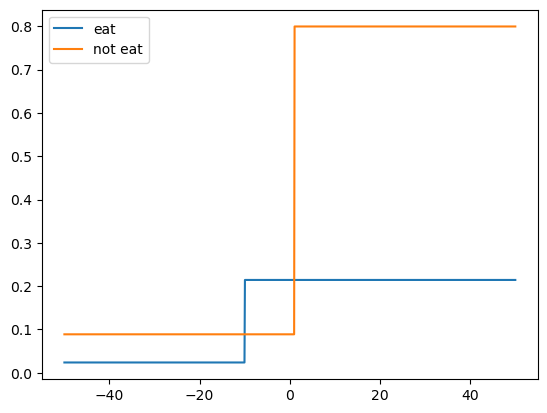

In [5]:
utility = {}
for d in ['eat', 'not eat']:
    tau = rnd_gen.uniform(0, 1)
    U_train_d = np.array([U(y, d) for y in y_train]).astype('float')

    cps = NearestNeighboursPredictionMachine(k=1, distance='hamming', rnd_state=2024)
    cps.learn_initial_training_set(X_train, U_train_d)
    cpd = cps.predict_cpd(X[N])

    # NOTE: There must be a better way to do the integral. The issue for now, is that I had to add random noise to
    #       labels to avoid duplicates in the NNPM. This complicates things here...

    yrange = np.linspace(-50, 50, num=1000, endpoint=True) 
    Q_star_values = np.array([cpd(y=y, tau=tau) for y in yrange])  # Corresponding Q^*(y) values at y_values

    # Compute the differences to find jumps
    delta_Q_star = np.diff(Q_star_values)
    jump_points = yrange[1:]  # Corresponding points are shifted by one due to diff

    # Filter for non-zero jumps
    nonzero_jumps = delta_Q_star != 0
    nonzero_delta_Q_star = delta_Q_star[nonzero_jumps]
    corresponding_y = jump_points[nonzero_jumps]

    # Output the results
    for y_val, delta in zip(corresponding_y, nonzero_delta_Q_star):
        print(f"d={d}: Jump at y={y_val}: ΔQ*={delta}")

    tau = rnd_gen.uniform(0, 1)
    plt.plot(
        yrange,
        [cpd(y=y, tau=tau) for y in yrange],
        label=d
    )

    utility[d] = corresponding_y @ nonzero_delta_Q_star

print(utility)
print(y[N])

plt.legend()